<a href="https://colab.research.google.com/github/MyDearGreatTeacher/TF/blob/master/TF_CNN_app1_NeuralStyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# stylenet and the neural-style 


TensorFlow機器學習實戰指南 (美)尼克‧麥克盧爾 機械工業

https://github.com/nfmcclure/tensorflow_cookbook

第8章 卷積神經網路

8.1 卷積神經網路介紹

8.2 用TensorFlow實現簡單的CNN

8.3 用TensorFlow實現進階的CNN

8.4 再訓練已有的CNN模型

8.5 用TensorFlow實現模仿大師繪畫

8.6 用TensorFlow實現DeepDream

08_Convolutional_Neural_Networks/06_Deepdream/06_deepdream.py'

https://github.com/nfmcclure/tensorflow_cookbook/tree/master/08_Convolutional_Neural_Networks/05_Stylenet_NeuralStyle


https://www.kaggle.com/teksab/imagenetvggverydeep19mat


http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

https://zhuanlan.zhihu.com/p/28897952

# 下載相關檔案

[1]模型http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

[2]風格

[3]你的圖片或照片

In [4]:
!wget  "http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat"

--2019-05-12 12:30:28--  http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 576042600 (549M) [text/plain]
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 549.36M  41.1MB/s    in 14s     

2019-05-12 12:30:42 (39.6 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [576042600/576042600]



In [13]:
!wget https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/08_Convolutional_Neural_Networks/images/starry_night.jpg

--2019-05-12 12:38:26--  https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/08_Convolutional_Neural_Networks/images/starry_night.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562577 (549K) [image/jpeg]
Saving to: ‘starry_night.jpg’

starry_night.jpg    100%[===================>] 549.39K  --.-KB/s    in 0.06s   

2019-05-12 12:38:26 (8.85 MB/s) - ‘starry_night.jpg’ saved [562577/562577]



In [15]:
!wget https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/08_Convolutional_Neural_Networks/images/book_cover.jpg

 https://raw.githubusercontent.com/nfmcclure/tensorflow_cookbook/master/08_Convolutional_Neural_Networks/images/book_cover.jpg: Scheme missing.


圖像的形狀:
[326 458   3]


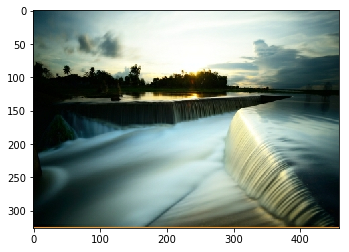

In [17]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#"讀取圖片檔"
image=tf.read_file("book_cover.jpg",'r')
#"將圖片檔解碼為Tensor"
image_tensor=tf.image.decode_jpeg(image)
#"圖像張量的形狀"
shape=tf.shape(image_tensor)
session=tf.Session()
print('圖像的形狀:')
print(session.run(shape))
#"Tensor 轉換為 ndarray"
image_ndarray=image_tensor.eval(session=session)
#"顯示圖片"
plt.imshow(image_ndarray)
plt.show()

#

In [19]:
# Using TensorFlow for Stylenet/NeuralStyle
#---------------------------------------
#
# We use two images, an original image and a style image
# and try to make the original image in the style of the style image.
#
# Reference paper:
# https://arxiv.org/abs/1508.06576
#
# Need to download the model 'imagenet-vgg-verydee-19.mat' from:
#   http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

import os
import scipy.io
import scipy.misc
import imageio
from skimage.transform import resize
from operator import mul
from functools import reduce
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Image Files
#original_image_file = 'images/book_cover.jpg'
#style_image_file = 'images/starry_night.jpg'

original_image_file = 'book_cover.jpg'
style_image_file = 'starry_night.jpg'

# Saved VGG Network path under the current project dir.
vgg_path = 'imagenet-vgg-verydeep-19.mat'

# Default Arguments
original_image_weight = 5.0
style_image_weight = 500.0
regularization_weight = 100
learning_rate = 10
generations = 100
output_generations = 25
beta1 = 0.9
beta2 = 0.999

# Read in images
original_image = imageio.imread(original_image_file)
style_image = imageio.imread(style_image_file)

# Get shape of target and make the style image the same
target_shape = original_image.shape
style_image = resize(style_image, target_shape)

# VGG-19 Layer Setup
# From paper
vgg_layers = ['conv1_1', 'relu1_1',
              'conv1_2', 'relu1_2', 'pool1',
              'conv2_1', 'relu2_1',
              'conv2_2', 'relu2_2', 'pool2',
              'conv3_1', 'relu3_1',
              'conv3_2', 'relu3_2',
              'conv3_3', 'relu3_3',
              'conv3_4', 'relu3_4', 'pool3',
              'conv4_1', 'relu4_1',
              'conv4_2', 'relu4_2',
              'conv4_3', 'relu4_3',
              'conv4_4', 'relu4_4', 'pool4',
              'conv5_1', 'relu5_1',
              'conv5_2', 'relu5_2',
              'conv5_3', 'relu5_3',
              'conv5_4', 'relu5_4']


# Extract weights and matrix means
def extract_net_info(path_to_params):
    vgg_data = scipy.io.loadmat(path_to_params)
    normalization_matrix = vgg_data['normalization'][0][0][0]
    mat_mean = np.mean(normalization_matrix, axis=(0,1))
    network_weights = vgg_data['layers'][0]
    return mat_mean, network_weights
    

# Create the VGG-19 Network
def vgg_network(network_weights, init_image):
    network = {}
    image = init_image

    for i, layer in enumerate(vgg_layers):
        if layer[0] == 'c':
            weights, bias = network_weights[i][0][0][0][0]
            weights = np.transpose(weights, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            conv_layer = tf.nn.conv2d(image, tf.constant(weights), (1, 1, 1, 1), 'SAME')
            image = tf.nn.bias_add(conv_layer, bias)
        elif layer[0] == 'r':
            image = tf.nn.relu(image)
        else:  # pooling
            image = tf.nn.max_pool(image, (1, 2, 2, 1), (1, 2, 2, 1), 'SAME')
        network[layer] = image
    return network

# Here we define which layers apply to the original or style image
original_layers = ['relu4_2', 'relu5_2']
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

# Get network parameters
normalization_mean, network_weights = extract_net_info(vgg_path)

shape = (1,) + original_image.shape
style_shape = (1,) + style_image.shape
original_features = {}
style_features = {}

# Set style weights
style_weights = {l: 1./(len(style_layers)) for l in style_layers}

# Computer feature layers with original image
g_original = tf.Graph()
with g_original.as_default(), tf.Session() as sess1:
    image = tf.placeholder('float', shape=shape)
    vgg_net = vgg_network(network_weights, image)
    original_minus_mean = original_image - normalization_mean
    original_norm = np.array([original_minus_mean])
    for layer in original_layers:
        original_features[layer] = vgg_net[layer].eval(feed_dict={image: original_norm})

# Get style image network
g_style = tf.Graph()
with g_style.as_default(), tf.Session() as sess2:
    image = tf.placeholder('float', shape=style_shape)
    vgg_net = vgg_network(network_weights, image)
    style_minus_mean = style_image - normalization_mean
    style_norm = np.array([style_minus_mean])
    for layer in style_layers:
        features = vgg_net[layer].eval(feed_dict={image: style_norm})
        features = np.reshape(features, (-1, features.shape[3]))
        gram = np.matmul(features.T, features) / features.size
        style_features[layer] = gram

# Make Combined Image via loss function
with tf.Graph().as_default():
    # Get network parameters
    initial = tf.random_normal(shape) * 0.256
    init_image = tf.Variable(initial)
    vgg_net = vgg_network(network_weights, init_image)

    # Loss from Original Image
    original_layers_w = {'relu4_2': 0.5, 'relu5_2': 0.5}
    original_loss = 0
    for o_layer in original_layers:
        temp_original_loss = original_layers_w[o_layer] * original_image_weight *\
                             (2 * tf.nn.l2_loss(vgg_net[o_layer] - original_features[o_layer]))
        original_loss += (temp_original_loss / original_features[o_layer].size)

    # Loss from Style Image
    style_loss = 0
    style_losses = []
    for style_layer in style_layers:
        layer = vgg_net[style_layer]
        feats, height, width, channels = [x.value for x in layer.get_shape()]
        size = height * width * channels
        features = tf.reshape(layer, (-1, channels))
        style_gram_matrix = tf.matmul(tf.transpose(features), features) / size
        style_expected = style_features[style_layer]
        style_losses.append(style_weights[style_layer] * 2 *
                            tf.nn.l2_loss(style_gram_matrix - style_expected) /
                            style_expected.size)
    style_loss += style_image_weight * tf.reduce_sum(style_losses)

    # To Smooth the results, we add in total variation loss
    total_var_x = reduce(mul, init_image[:, 1:, :, :].get_shape().as_list(), 1)
    total_var_y = reduce(mul, init_image[:, :, 1:, :].get_shape().as_list(), 1)
    first_term = regularization_weight * 2
    second_term_numerator = tf.nn.l2_loss(init_image[:, 1:, :, :] - init_image[:, :shape[1]-1, :, :])
    second_term = second_term_numerator / total_var_y
    third_term = (tf.nn.l2_loss(init_image[:, :, 1:, :] - init_image[:, :, :shape[2]-1, :]) / total_var_x)
    total_variation_loss = first_term * (second_term + third_term)

    # Combined Loss
    loss = original_loss + style_loss + total_variation_loss

    # Declare Optimization Algorithm
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2)
    train_step = optimizer.minimize(loss)

    # Initialize variables and start training
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(generations):

            train_step.run()

            # Print update and save temporary output
            if (i+1) % output_generations == 0:
                print('Generation {} out of {}, loss: {}'.format(i + 1, generations,sess.run(loss)))
                image_eval = init_image.eval()
                best_image_add_mean = image_eval.reshape(shape[1:]) + normalization_mean
                output_file = 'temp_output_{}.jpg'.format(i)
                imageio.imwrite(output_file, best_image_add_mean)
        
        
        # Save final image
        image_eval = init_image.eval()
        best_image_add_mean = image_eval.reshape(shape[1:]) + normalization_mean
        output_file = 'final_output.jpg'
        scipy.misc.imsave(output_file, best_image_add_mean)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Instructions for updating:
Colocations handled automatically by placer.


Generation 25 out of 100, loss: 10384137.0


Generation 50 out of 100, loss: 7902839.0


Generation 75 out of 100, loss: 6713909.0


Generation 100 out of 100, loss: 6169477.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:193: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


圖像的形狀:
[326 458   3]


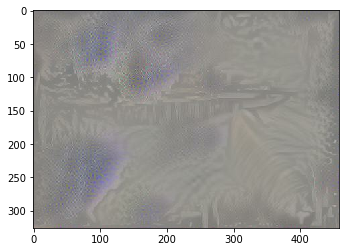

In [20]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#"讀取圖片檔"
image=tf.read_file("final_output.jpg",'r')
#"將圖片檔解碼為Tensor"
image_tensor=tf.image.decode_jpeg(image)
#"圖像張量的形狀"
shape=tf.shape(image_tensor)
session=tf.Session()
print('圖像的形狀:')
print(session.run(shape))
#"Tensor 轉換為 ndarray"
image_ndarray=image_tensor.eval(session=session)
#"顯示圖片"
plt.imshow(image_ndarray)
plt.show()